In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Ignore warnings
warnings.filterwarnings('ignore')


In [ ]:
#Load dataset
file_path = '/content/drive/MyDrive/titanic_final_dataset(1).csv'
df = pd.read_csv(file_path)
print("Dataset loaded successfully!")
print(df.info())
print(df.head())


Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passenger_id      900 non-null    int64  
 1   survived          900 non-null    object 
 2   ticket_class      898 non-null    object 
 3   name              900 non-null    object 
 4   sex               897 non-null    object 
 5   age               764 non-null    float64
 6   siblings_spouses  746 non-null    object 
 7   parents_children  749 non-null    object 
 8   ticket            897 non-null    object 
 9   fare              852 non-null    float64
 10  cabin             255 non-null    object 
 11  embarked          679 non-null    object 
 12  profession        782 non-null    object 
 13  travel_notes      791 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory usage: 98.6+ KB
None
   passenger_id survived ticket_class        

In [ ]:
#Handle missing values
print("Missing values before filling:\n", df.isnull().sum())


Missing values before filling:
 passenger_id          0
survived              0
ticket_class          2
name                  0
sex                   3
age                 136
siblings_spouses    154
parents_children    151
ticket                3
fare                 48
cabin               645
embarked            221
profession          118
travel_notes        109
dtype: int64


In [ ]:
# Fill missing numerical with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill missing categorical with mode
for col in df.select_dtypes(include=['object']):
    df[col].fillna(df[col].mode()[0], inplace=True)

print("Missing values after filling:\n", df.isnull().sum())



Missing values after filling:
 passenger_id        0
survived            0
ticket_class        0
name                0
sex                 0
age                 0
siblings_spouses    0
parents_children    0
ticket              0
fare                0
cabin               0
embarked            0
profession          0
travel_notes        0
dtype: int64


In [ ]:
#Encode categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
LabelEncoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    LabelEncoders[col] = le


In [ ]:
#Feature scaling
X = df.drop(columns=['survived'])
y = df['survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#Baseline Logistic Regression
model_lr = LogisticRegression(max_iter=1000, solver="liblinear")
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
y_proba = model_lr.predict_proba(X_test)[:, 1]

print("Baseline Logistic Regression")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))


Baseline Logistic Regression
Accuracy : 0.5666666666666667
Precision: 0.3157894736842105
Recall   : 0.08450704225352113
F1-score : 0.13333333333333333
ROC AUC  : 0.46905284920532364


In [ ]:
#Baseline Decision Tree
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_test)
y_proba = model_tree.predict_proba(X_test)[:, 1]

print("\nBaseline Decision Tree")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))



Baseline Decision Tree
Accuracy : 0.5
Precision: 0.379746835443038
Recall   : 0.4225352112676056
F1-score : 0.4
ROC AUC  : 0.4864969634319679


In [ ]:
#Hyperparameter search spaces

# Logistic Regression parameters
logreg_params = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}



In [ ]:
# Decision Tree parameters
tree_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}


In [ ]:
#This code is from chatgpt but i learn the concept
#GridSearchCV and RandomizedSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "f1"   # Because Titanic data is imbalanced

# Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, solver="liblinear"),
                       param_grid=logreg_params, cv=cv, scoring=scoring, n_jobs=-1)
rand_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000, solver="liblinear"),
                             param_distributions=logreg_params, n_iter=10, cv=cv,
                             scoring=scoring, n_jobs=-1, random_state=42)

grid_lr.fit(X_train, y_train)
rand_lr.fit(X_train, y_train)

# Decision Tree
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                         param_grid=tree_params, cv=cv, scoring=scoring, n_jobs=-1)
rand_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                               param_distributions=tree_params, n_iter=10, cv=cv,
                               scoring=scoring, n_jobs=-1, random_state=42)

grid_tree.fit(X_train, y_train)
rand_tree.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 3, 5, 7, 9],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='f1')

In [ ]:
#Evaluate best models on test set

def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC AUC  :", roc_auc_score(y_test, y_proba))

evaluate_model("LogReg - GridSearch Best", grid_lr.best_estimator_)
evaluate_model("LogReg - RandomSearch Best", rand_lr.best_estimator_)
evaluate_model("DecisionTree - GridSearch Best", grid_tree.best_estimator_)
evaluate_model("DecisionTree - RandomSearch Best", rand_tree.best_estimator_)



LogReg - GridSearch Best
Accuracy : 0.4888888888888889
Precision: 0.3764705882352941
Recall   : 0.4507042253521127
F1-score : 0.41025641025641024
ROC AUC  : 0.4663393203256235

LogReg - RandomSearch Best
Accuracy : 0.5
Precision: 0.3855421686746988
Recall   : 0.4507042253521127
F1-score : 0.4155844155844156
ROC AUC  : 0.46840677090063315

DecisionTree - GridSearch Best
Accuracy : 0.42777777777777776
Precision: 0.38235294117647056
Recall   : 0.7323943661971831
F1-score : 0.5024154589371981
ROC AUC  : 0.47299392686393593

DecisionTree - RandomSearch Best
Accuracy : 0.42777777777777776
Precision: 0.38235294117647056
Recall   : 0.7323943661971831
F1-score : 0.5024154589371981
ROC AUC  : 0.47299392686393593


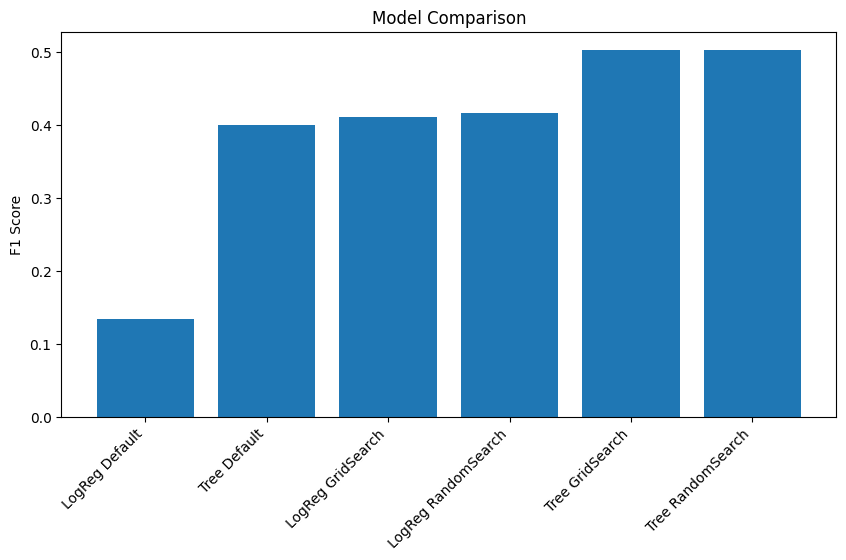

In [ ]:
#Compare F1 Scores with a bar plot
results = {
    "LogReg Default": f1_score(y_test, model_lr.predict(X_test)),
    "Tree Default": f1_score(y_test, model_tree.predict(X_test)),
    "LogReg GridSearch": f1_score(y_test, grid_lr.best_estimator_.predict(X_test)),
    "LogReg RandomSearch": f1_score(y_test, rand_lr.best_estimator_.predict(X_test)),
    "Tree GridSearch": f1_score(y_test, grid_tree.best_estimator_.predict(X_test)),
    "Tree RandomSearch": f1_score(y_test, rand_tree.best_estimator_.predict(X_test)),
}

plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Comparison")
plt.show()
